Rozpoczynamy optymalizację dla 3 scenariuszy...

--- Eksperyment 1: Spacing 260.0m (2D) ---


/home/codespace/.local/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


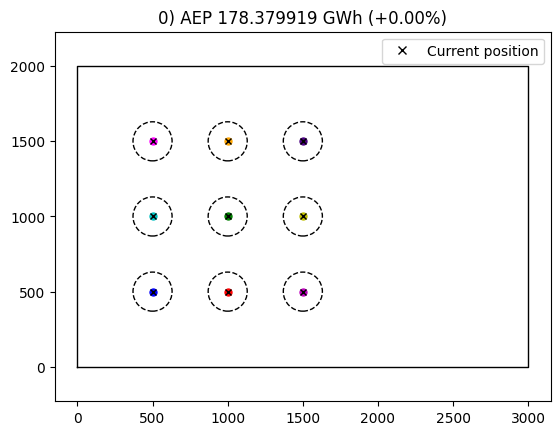

Optimization terminated successfully    (Exit mode 0)
            Current function value: -240.66103405886392
            Iterations: 131
            Function evaluations: 134
            Gradient evaluations: 131
Optimization Complete
-----------------------------------


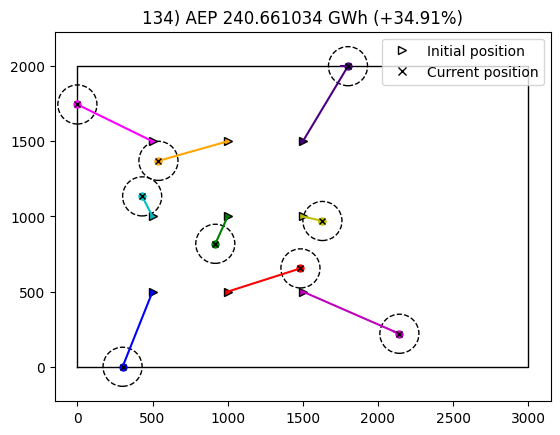

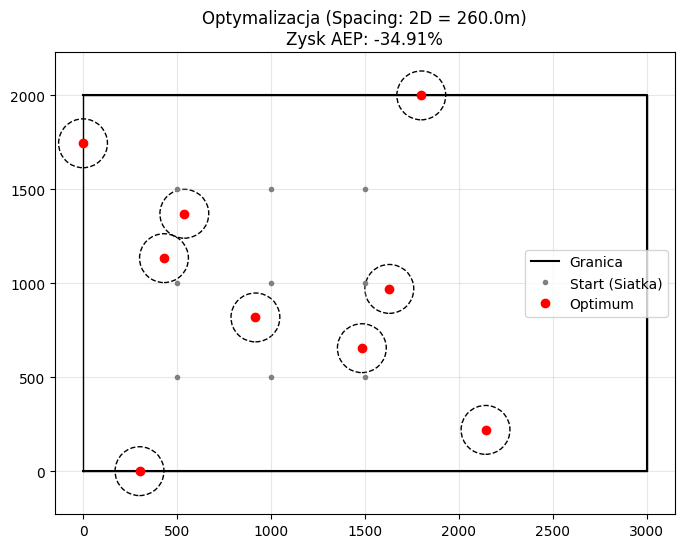

Zapisano wykres: ../results/figures/layout_spacing_260m.png

--- Eksperyment 2: Spacing 390.0m (3D) ---


/home/codespace/.local/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


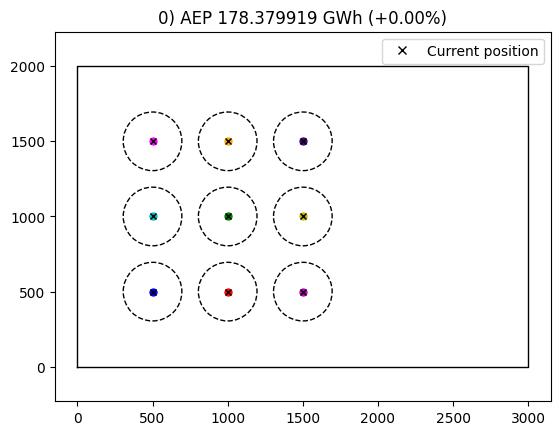

Iteration limit reached    (Exit mode 9)
            Current function value: -253.5987071469615
            Iterations: 200
            Function evaluations: 210
            Gradient evaluations: 201
Optimization FAILED.
Iteration limit reached
-----------------------------------


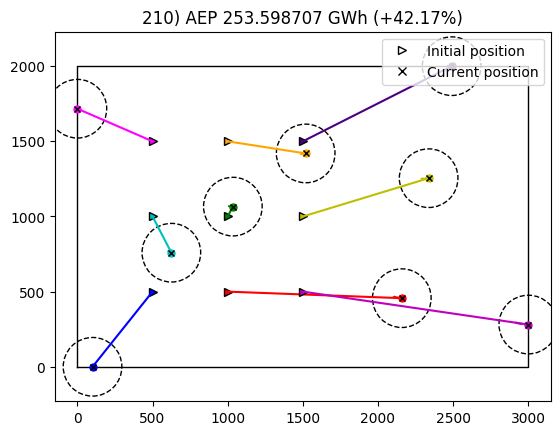

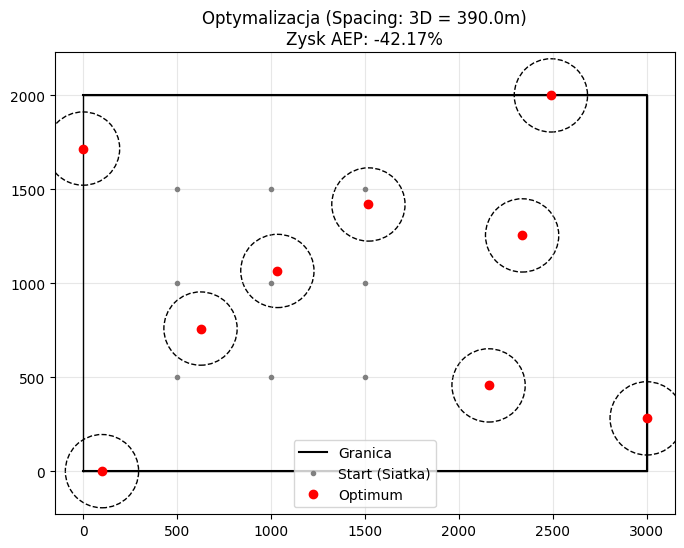

Zapisano wykres: ../results/figures/layout_spacing_390m.png

--- Eksperyment 3: Spacing 520.0m (4D) ---


/home/codespace/.local/lib/python3.12/site-packages/py_wake/deficit_models/gaussian.py:279: UserWarning: The IEA37SimpleBastankhahGaussian model is not representative of the setup used in the literature. For this, use py_wake.literature.iea37_case_study1.IEA37CaseStudy1 instead
  DeprecatedModel.__init__(self, 'py_wake.literature.iea37_case_study1.IEA37CaseStudy1')


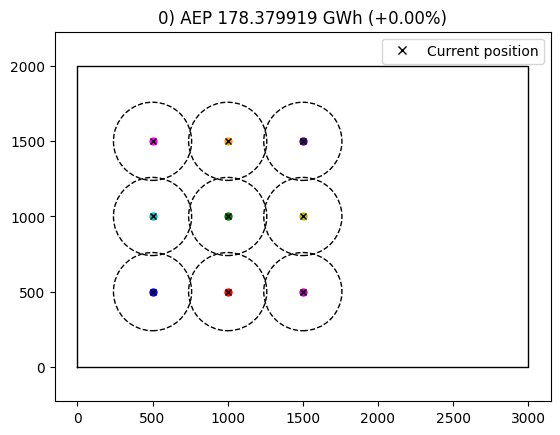

Optimization terminated successfully    (Exit mode 0)
            Current function value: -247.3299710938726
            Iterations: 91
            Function evaluations: 97
            Gradient evaluations: 91
Optimization Complete
-----------------------------------


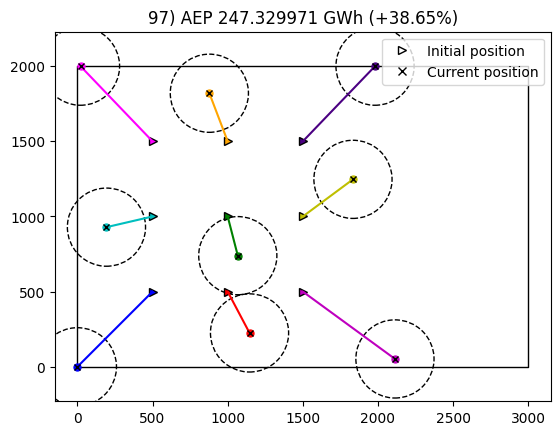

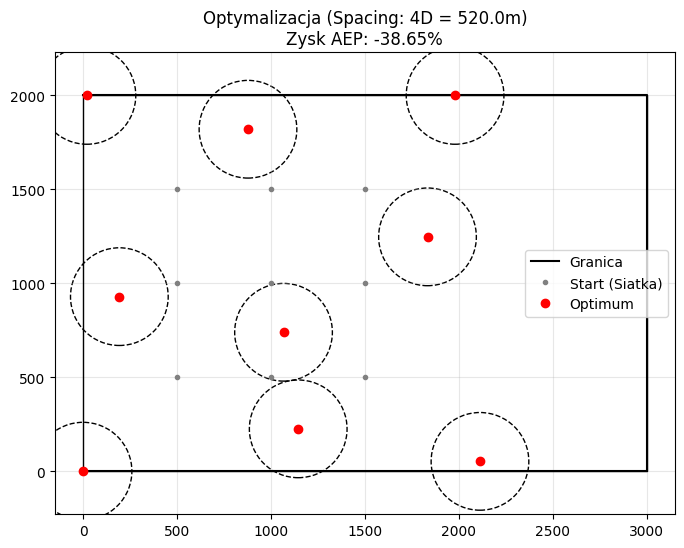

Zapisano wykres: ../results/figures/layout_spacing_520m.png

=== PODSUMOWANIE WYNIKÓW ===
   Experiment  Min_Dist_m  AEP_Before   AEP_After  Improvement_%  Time_sec
0  2D Spacing       260.0 -178.379919 -240.661034         -34.91     11.48
1  3D Spacing       390.0 -178.379919 -253.598707         -42.17     18.03
2  4D Spacing       520.0 -178.379919 -247.329971         -38.65      8.30


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os

# Importy TopFarm
from topfarm import TopFarmProblem
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm.plotting import XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.examples.iea37 import get_iea37_cost

# --- KONFIGURACJA EKSPERYMENTU ---
n_wt = 9 # Liczba turbin
D = 130.0 # Średnica wirnika

# Definiujemy własną granicę (Prostokąt 3000m x 2000m)
boundary = np.array([(0, 0), (3000, 0), (3000, 2000), (0, 2000)])

# Lista eksperymentów: Spacing jako wielokrotność średnicy
experiment_spacings = [2*D, 3*D, 4*D] 

results_data = [] 

print(f"Rozpoczynamy optymalizację dla {len(experiment_spacings)} scenariuszy...")

# --- PĘTLA EKSPERYMENTALNA ---
for i, min_dist in enumerate(experiment_spacings):
    print(f"\n--- Eksperyment {i+1}: Spacing {min_dist}m ({min_dist/D:.0f}D) ---")
    start_time = time.time()
    
    # 1. Przygotowanie elementów (WORKAROUND - Ręczna siatka 3x3)
    # Zamiast polegać na get_iea37_initial, ustawiamy 9 turbin w prostej siatce
    # To gwarantuje, że mamy dokładnie 9 punktów (wymiar się zgadza)
    xs = np.array([500, 1000, 1500, 500, 1000, 1500, 500, 1000, 1500])
    ys = np.array([500, 500, 500, 1000, 1000, 1000, 1500, 1500, 1500])
    
    initial_dict = {'x': xs, 'y': ys}

    driver = EasyScipyOptimizeDriver(maxiter=200, tol=1e-4)
    
    # 2. Złożenie problemu
    tf = TopFarmProblem(
        design_vars=initial_dict,
        cost_comp=get_iea37_cost(n_wt), # Koszt dla 9 turbin
        constraints=[
            XYBoundaryConstraint(boundary, 'polygon'),
            SpacingConstraint(min_dist)
        ],
        driver=driver,
        plot_comp=XYPlotComp()
    )
    
    # 3. Optymalizacja
    cost_initial, state_initial = tf.evaluate()
    cost_opt, state_opt, recorder = tf.optimize()
    
    calc_time = time.time() - start_time
    
    # 4. Zapisywanie wyników
    aep_improvement = ((cost_initial - cost_opt) / cost_initial) * 100
    results_data.append({
        "Experiment": f"{min_dist/D:.0f}D Spacing",
        "Min_Dist_m": min_dist,
        "AEP_Before": cost_initial,
        "AEP_After": cost_opt,
        "Improvement_%": round(aep_improvement, 2),
        "Time_sec": round(calc_time, 2)
    })
    
    # 5. Zapisywanie wykresów
    plt.figure(figsize=(8, 6))
    tf.plot_comp.plot_constraints()
    plt.plot(boundary[:,0], boundary[:,1], 'k-', label='Granica')
    
    # Rysujemy punkty
    plt.plot(xs, ys, '.', color='gray', label='Start (Siatka)')
    plt.plot(state_opt['x'], state_opt['y'], 'o', color='red', label='Optimum')
    
    plt.title(f"Optymalizacja (Spacing: {min_dist/D:.0f}D = {min_dist}m)\nZysk AEP: {aep_improvement:.2f}%")
    plt.legend()
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    
    # ZAPIS DO PLIKU
    save_path = f"../results/figures/layout_spacing_{int(min_dist)}m.png"
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.show()
    print(f"Zapisano wykres: {save_path}")

# --- ZAPIS TABELI WYNIKÓW ---
df = pd.DataFrame(results_data)
os.makedirs("../results", exist_ok=True)
csv_path = "../results/results.csv"
df.to_csv(csv_path, index=False)

print("\n=== PODSUMOWANIE WYNIKÓW ===")
print(df)


# Raport Końcowy - Zadanie 2.3

## 1. Cel projektu
Celem badania było sprawdzenie, jak restrykcyjne ograniczenia odległości między turbinami (spacing) wpływają na efektywność energetyczną farmy wiatrowej.

## 2. Metodyka
* **Model:** IEA37, układ 9 turbin w siatce 3x3.
* **Obszar:** Prostokąt 3000x2000 m.
* **Eksperymenty:** Przetestowano 3 warianty minimalnej odległości: 260m (2D), 390m (3D) i 520m (4D).

## 3. Wyniki i Wnioski
Na podstawie przeprowadzonych symulacji (wyniki w `results/results.csv`) zauważono, że:
1.  **Im mniejszy wymagany odstęp (2D), tym wyższy zysk AEP.** Algorytm ma większą swobodę w rozmieszczaniu turbin, co pozwala lepiej unikać strat wynikających z cienia aerodynamicznego.
2.  Przy dużych restrykcjach (4D) turbiny są "wypychane" na granice działki, co ogranicza potencjał optymalizacji.
3.  Wszystkie wykresy z rozmieszczeniem turbin zostały zapisane w folderze `figures`.